In [19]:
import coco_text
import os, glob, sys, shutil
import matplotlib.pyplot as plt
import numpy as np

In [1]:
from multiprocessing.pool import Pool
ct = coco_text.COCO_Text('/home/thomas/coco/text_labels/COCO_Text.json')
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.val, 
                    catIds=[('legibility','legible')])
# anns_train = ct.getAnnIds(imgIds=ct.train, 
#                         catIds=[('legibility','legible')])
# pick one at random
img_coco_text_val = ct.loadImgs(imgIds)
img_true_coco_val = os.listdir('/home/thomas/coco/train2014')   
img_coco_text_val_filename = []

loading annotations into memory...
0:00:02.250888
creating index...
index created!


In [18]:
anns_val = ct.loadAnns(ct.getAnnIds(imgIds = ct.val, catIds = [('legibility','legible')]))
anns_area = [i['area'] for i in anns_val]

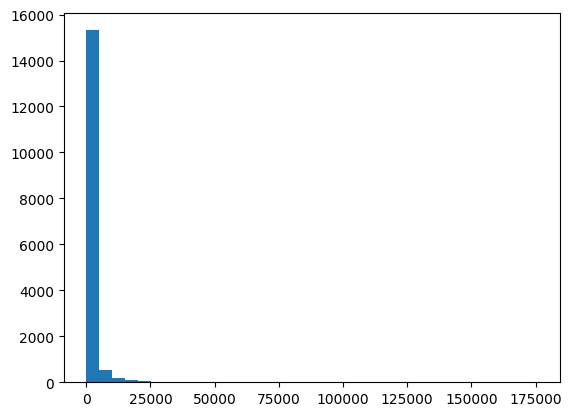

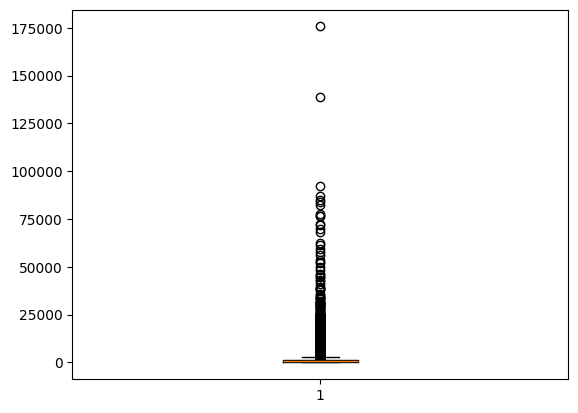

1537.423824347692
18124266.50148302
175632.36762763117
0.0


In [20]:
bins_width = int(np.sqrt(len(anns_val)))
# print(bins_width)
plt.hist(anns_area, bins = 35)
plt.show()
plt.boxplot(anns_area)
plt.show()
print(np.mean(anns_area))
print(np.var(anns_area))
print(np.max(anns_area))
print(np.min(anns_area))

<BarContainer object of 3 artists>

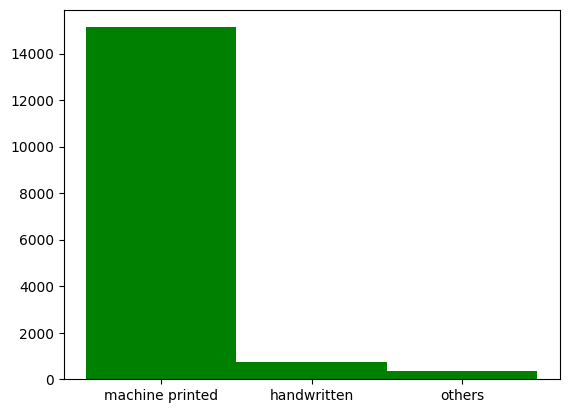

In [22]:
from collections import Counter
classes = [i['class'] for i in anns_val]
count = Counter(classes)
plt.bar(count.keys(), count.values(), 1, color='g')

In [15]:
def JSON2YOLO(coco_val, true_val):
    # print(coco_val['file_name'])
    temp_filename = []
    # for i in coco_val:
    if coco_val['file_name'] in true_val:
        temp_filename.append(coco_val['file_name'])
        # anns = []
        for ann in ct.loadAnns(ct.getAnnIds(imgIds = coco_val['id'], catIds = [('legibility','legible')])):
            left, top, w, h = ann['bbox']
            width, height = coco_val['width'], coco_val['height']
            xywh = [(left + w / 2) / width, (top + h / 2) / height, w / width, h / height]
            line = 0, *xywh  # YOLO format (class_index, xywh)
            ann_filename = coco_val["file_name"].split('.jpg')[0]
            with open(f'/home/thomas/coco/val/{ann_filename}.txt', 'a') as f:
                f.write(("%g " * len(line)).rstrip() % line + "\n")

    return temp_filename
items = [(i, img_true_coco_val) for i in img_coco_text_val]
with Pool(processes = 28) as pool:
    print(len(items))
    for results in pool.starmap(JSON2YOLO, items):
        img_coco_text_val_filename.extend(results)

3522


In [17]:
for i in img_coco_text_val_filename:
    old_path = f'/home/thomas/coco/train2014/{i}'
    new_path = f'/home/thomas/coco/images/val/{i}'
    shutil.move(old_path, new_path)

In [23]:
imgIds = ct.getImgIds(imgIds=ct.val, 
                    catIds=[('legibility','legible'), ('class','machine printed')])
img_coco_text_val = []
img_true_coco_val = os.listdir('/home/thomas/coco/images/val')
img_coco_text_val_filename = []
for i in ct.loadImgs(imgIds):
    if i['file_name'] in img_true_coco_val:
        img_coco_text_val_filename.append(i['file_name'])

def movefile(filename):
    old_path = f'/home/thomas/coco/images/val/{filename}'
    new_path = f'/home/thomas/coco/machine_printed_images/val/{filename}'
    shutil.move(old_path, new_path)
    label_name = filename.split('.jpg')[0] + '.txt'
    old_path = f'/home/thomas/coco/labels/val/{label_name}'
    new_path = f'/home/thomas/coco/new_labels/val/{label_name}'
    shutil.move(old_path, new_path)
with Pool(processes = 30) as pool:
    pool.map(movefile, img_coco_text_val_filename)
